# Projek UAS

# Business Understanding

## Latar Belakang

Pemeriksaan keamanan menggunakan citra X-ray bagasi merupakan proses penting untuk mendeteksi keberadaan perangkat listrik tersembunyi (electric devices) di dalam tas atau koper. Proses inspeksi manual oleh petugas keamanan memiliki keterbatasan, antara lain:

- Ketergantungan pada pengalaman operator
- Potensi kelelahan manusia
- Waktu pemeriksaan yang terbatas

Oleh karena itu, diperlukan sistem otomatis berbasis machine learning yang mampu membantu proses deteksi perangkat listrik secara cepat dan konsisten.

## Tujuan Bisnis

Tujuan dari proyek ini adalah:

- Membangun model klasifikasi yang dapat mendeteksi ada atau tidaknya perangkat listrik pada citra X-ray bagasi
- Menyediakan sistem yang dapat diintegrasikan ke aplikasi (deployment)
- Memberikan confidence score dan penjelasan model (explainability) untuk mendukung pengambilan keputusan

## Definisi Masalah

Masalah diformulasikan sebagai binary classification:

0 → Tidak terdapat perangkat listrik

1 → Terdapat perangkat listrik

# Data Understanding

## Deskripsi Dataset

Dataset yang digunakan adalah ElectricDeviceDetection dengan format .arff, terdiri dari:

- 256 fitur numerik (att1 – att256)
- 1 label target (target)

Setiap sampel merepresentasikan histogram intensitas voxel dari citra X-ray 3D yang telah diproyeksikan menjadi sinyal 1D.

Mengapa Dataset Termasuk Data Time Series?

Meskipun bukan time series dalam arti waktu eksplisit, dataset ini dipandang sebagai data time series karena:

- Fitur att1 hingga att256 merepresentasikan urutan bin histogram
- Setiap fitur memiliki urutan tetap dan saling bergantung
- Pola antar-bin membentuk sinyal 1D berurutan

Karena sifat ini:

- Model seperti DTW, CNN-1D, dan PCA berbasis urutan menjadi relevan
- Visualisasi dilakukan dengan line plot, bukan scatter antar fitur

## Load Library

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import arff
import seaborn as sns


## LOAD DATA & KONVERSI LABEL

In [5]:
# Load training data
data_train, meta_train = arff.loadarff("/content/drive/MyDrive/dataset/ElectricDeviceDetection/ElectricDeviceDetection_TRAIN.arff")
df_train = pd.DataFrame(data_train)

# Load testing data
data_test, meta_test = arff.loadarff("/content/drive/MyDrive/dataset/ElectricDeviceDetection/ElectricDeviceDetection_TEST.arff")
df_test = pd.DataFrame(data_test)

print("Shape Train:", df_train.shape)
print("Shape Test :", df_test.shape)


Shape Train: (624, 257)
Shape Test : (3768, 257)


## CEK STRUKTUR DATA

In [6]:
# Konversi target dari byte ke int
df_train["target"] = df_train["target"].apply(lambda x: int(x.decode()))
df_test["target"]  = df_test["target"].apply(lambda x: int(x.decode()))

# Info struktur data
print("INFO TRAIN")
df_train.info()

print("\nINFO TEST")
df_test.info()


INFO TRAIN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Columns: 257 entries, att1 to target
dtypes: float64(256), int64(1)
memory usage: 1.2 MB

INFO TEST
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3768 entries, 0 to 3767
Columns: 257 entries, att1 to target
dtypes: float64(256), int64(1)
memory usage: 7.4 MB


In [7]:
print("Shape Train:", df_train.shape)
print("Shape Test :", df_test.shape)


Shape Train: (624, 257)
Shape Test : (3768, 257)


## DISTRIBUSI KELAS

target
0    543
1     81
Name: count, dtype: int64


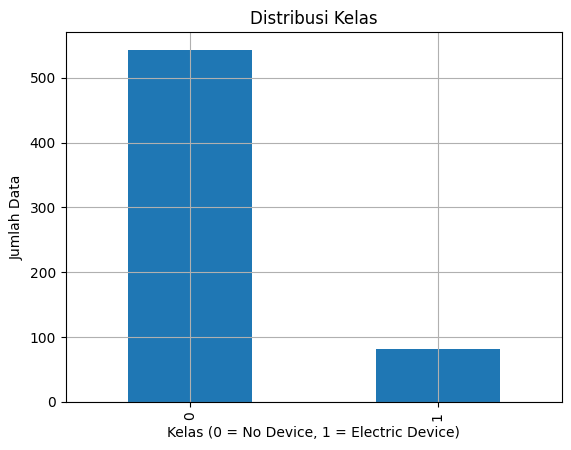

In [5]:
import matplotlib.pyplot as plt

class_counts = df_train["target"].value_counts()
print(class_counts)

plt.figure()
class_counts.plot(kind="bar")
plt.title("Distribusi Kelas")
plt.xlabel("Kelas (0 = No Device, 1 = Electric Device)")
plt.ylabel("Jumlah Data")
plt.grid(True)
plt.show()


## MISSING VALUE CHECK

Missing Train: 0
Missing Test : 0


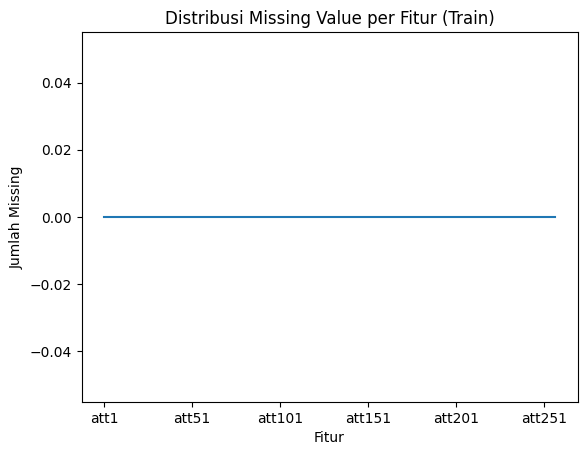

In [7]:
missing_train = df_train.isnull().sum().sum()
missing_test  = df_test.isnull().sum().sum()

print("Missing Train:", missing_train)
print("Missing Test :", missing_test)

plt.figure()
df_train.isnull().sum().plot()
plt.title("Distribusi Missing Value per Fitur (Train)")
plt.xlabel("Fitur")
plt.ylabel("Jumlah Missing")
plt.show()


## STATISTIK DESKRIPTIF

In [8]:
X_train = df_train.drop(columns=["target"])

X_train.describe().T.head(10)


,count,mean,std,min,25%,50%,75%,max
att1,624.0,2.836538,40.269345,0.0,0.0,0.0,0.0,900.0
att2,624.0,2.506410,36.661875,0.0,0.0,0.0,0.0,867.0
att3,624.0,4.232372,77.784648,0.0,0.0,0.0,0.0,1920.0
att4,624.0,3.451923,48.111904,0.0,0.0,0.0,0.0,1126.0
att5,624.0,4.493590,53.190532,0.0,0.0,0.0,0.0,1099.0
att6,624.0,6.312500,67.792953,0.0,0.0,0.0,0.0,1053.0
att7,624.0,1865.073718,17455.608429,0.0,0.0,0.0,0.0,288432.0
att8,624.0,3697.051282,33494.490772,0.0,0.0,0.0,0.0,566847.0
att9,624.0,3106.697115,25882.866378,0.0,0.0,0.0,0.0,451346.0
att10,624.0,3044.035256,21357.493766,0.0,0.0,0.0,0.0,384607.0


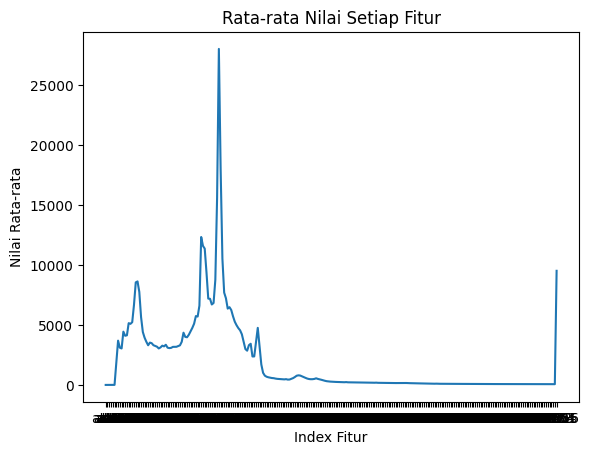

In [9]:
plt.figure()
plt.plot(X_train.mean())
plt.title("Rata-rata Nilai Setiap Fitur")
plt.xlabel("Index Fitur")
plt.ylabel("Nilai Rata-rata")
plt.show()


## DISTRIBUSI NILAI FITUR (GLOBAL)

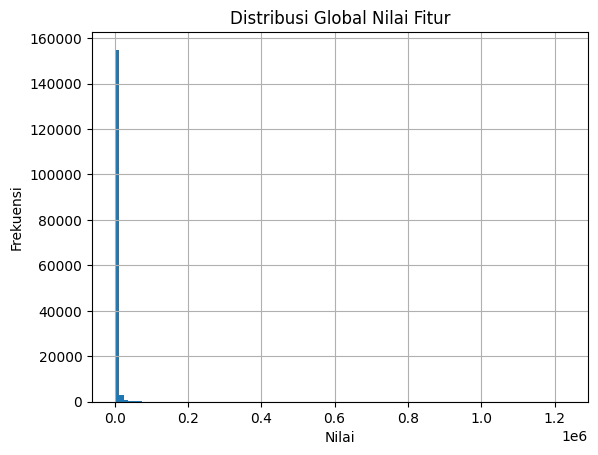

In [10]:
plt.figure()
plt.hist(X_train.values.flatten(), bins=100)
plt.title("Distribusi Global Nilai Fitur")
plt.xlabel("Nilai")
plt.ylabel("Frekuensi")
plt.grid(True)
plt.show()


## VISUALISASI 1 SAMPEL

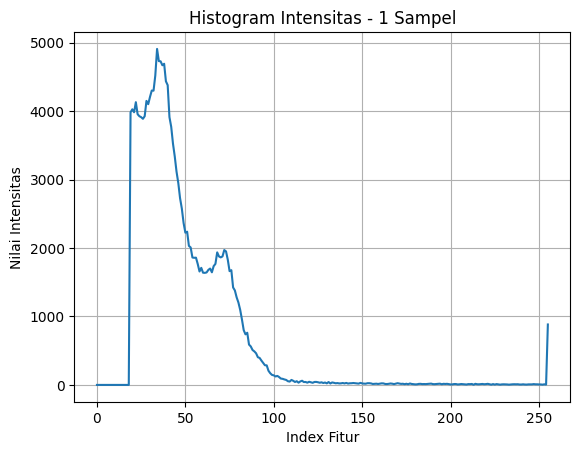

In [11]:
plt.figure()
plt.plot(X_train.iloc[0].values)
plt.title("Histogram Intensitas - 1 Sampel")
plt.xlabel("Index Fitur")
plt.ylabel("Nilai Intensitas")
plt.grid(True)
plt.show()


## PERBANDINGAN RATA-RATA PER KELAS

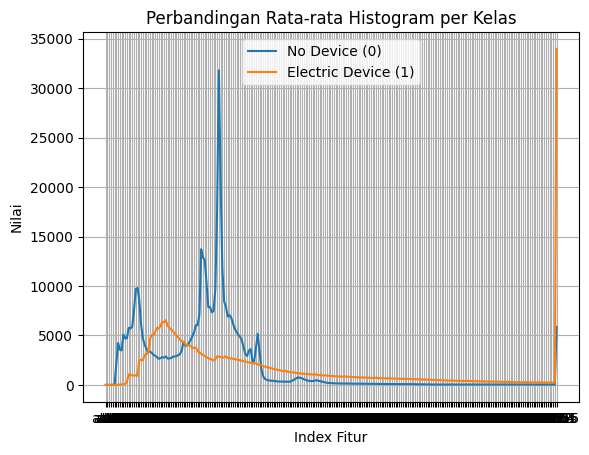

In [12]:
y_train = df_train["target"]

mean_no_device = X_train[y_train == 0].mean()
mean_device    = X_train[y_train == 1].mean()

plt.figure()
plt.plot(mean_no_device, label="No Device (0)")
plt.plot(mean_device, label="Electric Device (1)")
plt.legend()
plt.title("Perbandingan Rata-rata Histogram per Kelas")
plt.xlabel("Index Fitur")
plt.ylabel("Nilai")
plt.grid(True)
plt.show()


# HEATMAP KORELASI

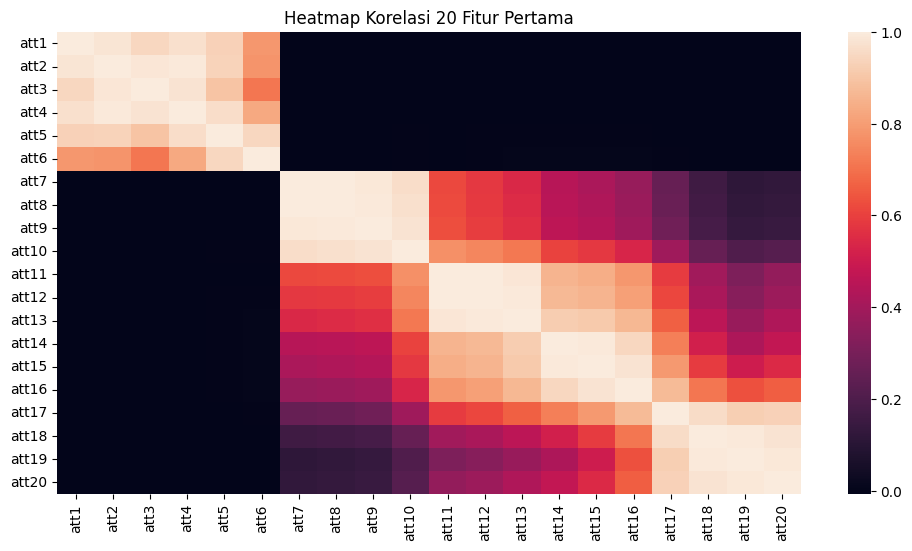

In [13]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(X_train.iloc[:, :20].corr())
plt.title("Heatmap Korelasi 20 Fitur Pertama")
plt.show()


# OUTLIER DETECTION (Z-SCORE)

Total Outlier: 2990


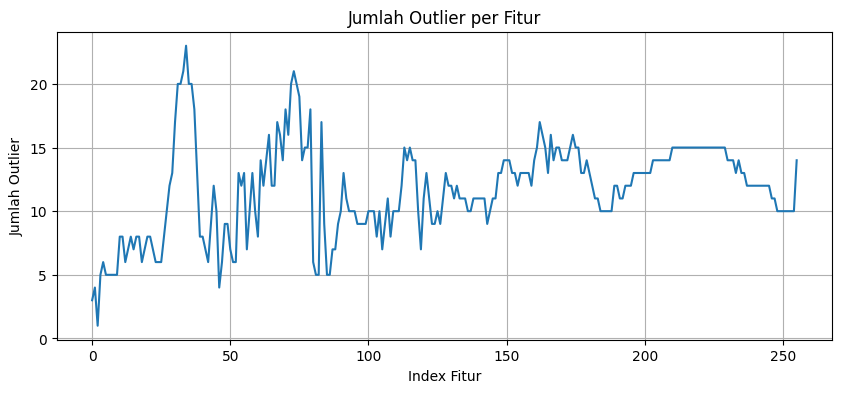

In [14]:
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt

# Hitung z-score
z_scores = np.abs(zscore(X_train))

# Outlier PER FITUR (sum per kolom / per fitur)
outliers_per_feature = (z_scores > 3).sum(axis=0)

# Total outlier keseluruhan
total_outliers = outliers_per_feature.sum()

print("Total Outlier:", total_outliers)

# Visualisasi jumlah outlier per fitur
plt.figure(figsize=(10, 4))
plt.plot(outliers_per_feature)
plt.title("Jumlah Outlier per Fitur")
plt.xlabel("Index Fitur")
plt.ylabel("Jumlah Outlier")
plt.grid(True)
plt.show()


In [15]:
outlier_df = pd.DataFrame({
    "Fitur": X_train.columns,
    "Jumlah_Outlier": outliers_per_feature
}).sort_values(by="Jumlah_Outlier", ascending=False)

outlier_df.head(10)


,Fitur,Jumlah_Outlier
34,att35,23
33,att34,21
73,att74,21
31,att32,20
35,att36,20
36,att37,20
72,att73,20
32,att33,20
74,att75,20
75,att76,19


# VARIANSI FITUR

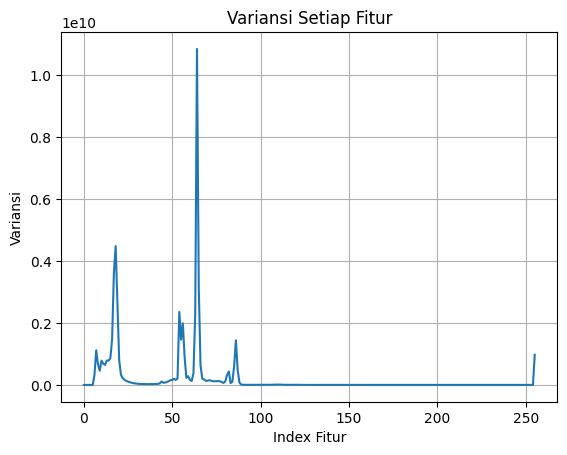

In [16]:
variances = X_train.var()

plt.figure()
plt.plot(variances.values)
plt.title("Variansi Setiap Fitur")
plt.xlabel("Index Fitur")
plt.ylabel("Variansi")
plt.grid(True)
plt.show()


## Temuan Awal dari EDA

Berdasarkan eksplorasi data:
- Dataset tidak memiliki missing value
- Distribusi kelas tidak seimbang (kelas non-device lebih dominan)
- Nilai fitur memiliki:
  - Skewness tinggi
  - Banyak nilai nol
  - Rentang nilai sangat besar (outlier alami)

Outlier tidak dihapus, karena:

- Outlier merupakan bagian dari pola fisik citra X-ray
- Intensitas tinggi bisa menandakan material padat atau perangkat listrik
- Model pohon dan boosting cukup robust terhadap outlier

# Data Preparation

## PREPROCESSING

### Penggabungan Dataset

Dataset TRAIN dan TEST digabung, kemudian dibagi ulang menjadi:

- 60% Training
- 20% Testing (Evaluasi Model)
- 20% Deployment Testing

Tujuan:
- Menghindari bias pembagian awal
- Menyediakan data realistis untuk pengujian aplikasi

In [8]:
# Pisahkan fitur dan target
# Gabungkan dataset
df_all = pd.concat([df_train, df_test], ignore_index=True)

X = df_all.drop(columns=["target"])
y = df_all["target"]

from sklearn.model_selection import train_test_split

# 60% training
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.4,
    stratify=y,
    random_state=42
)

# 20% test model, 20% deployment
X_test, X_deploy, y_test, y_deploy = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)


print("X_train:", X_train.shape)
print("X_test :", X_test.shape)


X_train: (2635, 256)
X_test : (878, 256)


### Tahapan Preprocessing
Langkah preprocessing yang dilakukan:

1. Handling Missing Value

- Tidak ditemukan missing value, namun tetap disiapkan pengamanan (fillna(0))

2. Outlier Handling

- Menggunakan clipping quantile 1%–99%
- Mengurangi ekstrem tanpa menghilangkan informasi penting

3. Feature Scaling

- Menggunakan StandardScaler
- Penting untuk PCA, SVM, dan CNN

4. Dimensionality Reduction (PCA)

- PCA dengan 95% explained variance
- Dimensi berkurang dari 256 → 22 fitur
- Mengurangi noise dan multikolinearitas

#### VALIDASI & PENANGANAN MISSING VALUE

In [9]:
print("Missing X_train:", X_train.isnull().sum().sum())
print("Missing X_test :", X_test.isnull().sum().sum())

# Jika ada missing value (antisipasi keamanan)
X_train = X_train.fillna(0)
X_test  = X_test.fillna(0)


Missing X_train: 0
Missing X_test : 0


#### HANDLING OUTLIER DENGAN CLIPPING

In [10]:
X_train_clipped = X_train.clip(lower=X_train.quantile(0.01),
                               upper=X_train.quantile(0.99),
                               axis=1)

X_test_clipped  = X_test.clip(lower=X_train.quantile(0.01),
                              upper=X_train.quantile(0.99),
                              axis=1)


#### FEATURE SCALING

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_clipped)
X_test_scaled  = scaler.transform(X_test_clipped)

print(X_train_scaled.shape, X_test_scaled.shape)


(2635, 256) (878, 256)


#### PCA – REDUKSI DIMENSI

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

X_deploy_scaled = scaler.transform(X_deploy)
X_deploy_pca    = pca.transform(X_deploy_scaled)


print("Sebelum PCA:", X_train_scaled.shape[1])
print("Sesudah PCA :", X_train_pca.shape[1])


Sebelum PCA: 256
Sesudah PCA : 22


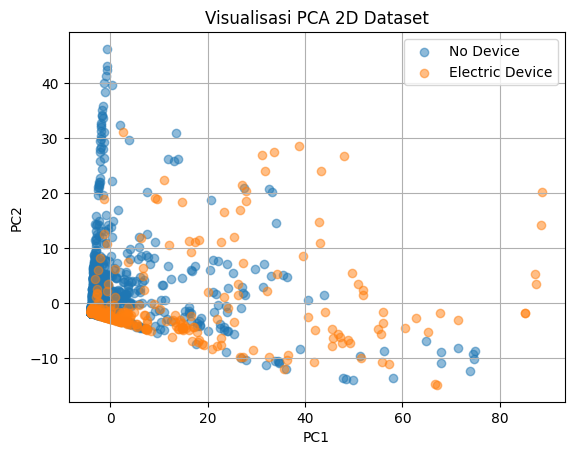

In [13]:
pca_2d = PCA(n_components=2)
X_train_2d = pca_2d.fit_transform(X_train_scaled)

plt.figure()
plt.scatter(X_train_2d[y_train==0, 0], X_train_2d[y_train==0, 1], label="No Device", alpha=0.5)
plt.scatter(X_train_2d[y_train==1, 0], X_train_2d[y_train==1, 1], label="Electric Device", alpha=0.5)
plt.legend()
plt.title("Visualisasi PCA 2D Dataset")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


### FINAL OUTPUT UNTUK MODELING

In [14]:
X_train_final = X_train_pca
X_test_final  = X_test_pca


In [15]:
print("Final Train Shape:", X_train_final.shape)
print("Final Test  Shape:", X_test_final.shape)

print("Label Train:", y_train.shape)
print("Label Test :", y_test.shape)


Final Train Shape: (2635, 22)
Final Test  Shape: (878, 22)
Label Train: (2635,)
Label Test : (878,)


# Modeling

Pada tahap modeling, beberapa algoritma machine learning diuji untuk membandingkan performa klasifikasi, yaitu:

1. Random Forest : Robust, baseline kuat
2. Support Vector Machine (SVM) : Cocok untuk data high-dimensional
3. XGBoost : Menangani non-linear & imbalance dengan baik
4. CNN 1D : Memanfaatkan sifat sekuensial histogram

Pemilihan model dilakukan untuk mengevaluasi berbagai pendekatan:

- Tree-based models untuk menangkap hubungan non-linear
- Margin-based model (SVM) untuk data berdimensi tinggi
- Time-series inspired method (DTW)
- Deep learning (CNN 1D)

Pemilihan model terbaik didasarkan pada kemampuan mendeteksi perangkat listrik secara seimbang, bukan sekadar akurasi keseluruhan.

RANDOM FOREST

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
from tqdm import tqdm

n_trees = 300
rf = RandomForestClassifier(
    n_estimators=1,
    warm_start=True,
    random_state=42,
    class_weight="balanced"
)

start_time = time.time()

for i in tqdm(range(1, n_trees + 1), desc="Training Random Forest"):
    rf.n_estimators = i
    rf.fit(X_train_final, y_train)

total_time = time.time() - start_time

rf_pred = rf.predict(X_test_final)

print(f"\nRandom Forest Training Time: {total_time:.2f} seconds")


Training Random Forest:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the cl


Random Forest Training Time: 4.03 seconds


In [17]:
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))
print(confusion_matrix(y_test, rf_pred))

Random Forest Accuracy: 0.9111617312072893
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       756
           1       0.78      0.50      0.61       122

    accuracy                           0.91       878
   macro avg       0.85      0.74      0.78       878
weighted avg       0.90      0.91      0.90       878

[[739  17]
 [ 61  61]]


SVM (Support Vector Machine)

In [18]:
from sklearn.svm import SVC
import time

svm = SVC(
    kernel='rbf',
    C=3,
    gamma='scale',
    probability=True,
    class_weight="balanced",
    random_state=42
)

start_time = time.time()
svm.fit(X_train_final, y_train)
total_time = time.time() - start_time

svm_pred = svm.predict(X_test_final)

print(f"SVM Training Time: {total_time:.2f} seconds")

SVM Training Time: 1.03 seconds


In [19]:
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred))
print(confusion_matrix(y_test, svm_pred))

SVM Accuracy: 0.8667425968109339
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       756
           1       0.52      0.70      0.59       122

    accuracy                           0.87       878
   macro avg       0.73      0.80      0.76       878
weighted avg       0.89      0.87      0.87       878

[[676  80]
 [ 37  85]]


XGBOOST

In [20]:
from xgboost import XGBClassifier
import time

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

start_time = time.time()

xgb.fit(
    X_train_final, y_train,
    eval_set=[(X_test_final, y_test)],
    verbose=True
)

total_time = time.time() - start_time

xgb_pred = xgb.predict(X_test_final)

print(f"\nXGBoost Training Time: {total_time:.2f} seconds")


[0]	validation_0-logloss:0.38684
[1]	validation_0-logloss:0.37205
[2]	validation_0-logloss:0.36082
[3]	validation_0-logloss:0.35220
[4]	validation_0-logloss:0.34251
[5]	validation_0-logloss:0.33422
[6]	validation_0-logloss:0.32683
[7]	validation_0-logloss:0.31999
[8]	validation_0-logloss:0.31354
[9]	validation_0-logloss:0.30850
[10]	validation_0-logloss:0.30294
[11]	validation_0-logloss:0.29763
[12]	validation_0-logloss:0.29220
[13]	validation_0-logloss:0.28835
[14]	validation_0-logloss:0.28590
[15]	validation_0-logloss:0.28255
[16]	validation_0-logloss:0.27830
[17]	validation_0-logloss:0.27517
[18]	validation_0-logloss:0.27218
[19]	validation_0-logloss:0.26905
[20]	validation_0-logloss:0.26612
[21]	validation_0-logloss:0.26293
[22]	validation_0-logloss:0.26039
[23]	validation_0-logloss:0.25836
[24]	validation_0-logloss:0.25634
[25]	validation_0-logloss:0.25475
[26]	validation_0-logloss:0.25315
[27]	validation_0-logloss:0.25080
[28]	validation_0-logloss:0.24931
[29]	validation_0-loglos

In [21]:
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))
print(confusion_matrix(y_test, xgb_pred))

XGBoost Accuracy: 0.9111617312072893
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       756
           1       0.72      0.60      0.65       122

    accuracy                           0.91       878
   macro avg       0.83      0.78      0.80       878
weighted avg       0.91      0.91      0.91       878

[[727  29]
 [ 49  73]]


CNN 1D (Deep Learning)

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.callbacks import Callback
import time

# Gunakan data sebelum PCA
X_train_cnn = X_train_scaled
X_test_cnn  = X_test_scaled

# Reshape: (samples, timesteps, channels)
X_train_cnn = X_train_cnn.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1], 1)
X_test_cnn  = X_test_cnn.reshape(X_test_cnn.shape[0], X_test_cnn.shape[1], 1)


model = Sequential([
    Conv1D(32, kernel_size=5, activation='relu', input_shape=(256, 1)),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.start_time
        progress = (epoch + 1) / self.params['epochs'] * 100
        print(f"Progress: {progress:.1f}% | Elapsed: {elapsed:.1f}s")

    def on_train_end(self, logs=None):
        total = time.time() - self.start_time
        print(f"\nTotal CNN Training Time: {total:.2f} seconds")

time_callback = TimeHistory()

history = model.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[time_callback]
)

cnn_pred = (model.predict(X_test_cnn) > 0.5).astype(int)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8611 - loss: 0.3892 - val_accuracy: 0.8805 - val_loss: 0.2907
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8924 - loss: 0.2993 - val_accuracy: 0.8861 - val_loss: 0.2909
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8969 - loss: 0.2710 - val_accuracy: 0.8918 - val_loss: 0.2846
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9032 - loss: 0.2409 - val_accuracy: 0.8861 - val_loss: 0.2853
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9016 - loss: 0.2409 - val_accuracy: 0.8786 - val_loss: 0.2964
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9063 - loss: 0.2236 - val_accuracy: 0.8843 - val_loss: 0.2785
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9132 - loss: 0.2097 - val_accuracy: 0.8748 - val_loss: 0.2933
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9073 - loss: 0.2180 - val_accuracy: 0.8786 - val_loss

In [28]:
print("CNN-1D Accuracy:", accuracy_score(y_test, cnn_pred))
print(classification_report(y_test, cnn_pred))
print(confusion_matrix(y_test, cnn_pred))

CNN-1D Accuracy: 0.9020501138952164
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       756
           1       0.66      0.62      0.64       122

    accuracy                           0.90       878
   macro avg       0.80      0.79      0.79       878
weighted avg       0.90      0.90      0.90       878

[[716  40]
 [ 46  76]]


# Evaluation
Evaluasi dilakukan menggunakan:
- Accuracy
- Precision, Recall, F1-score (fokus kelas Electric Device)
- Confusion Matrix
- Perbandingan multi-model
- Visualisasi PCA 2D

## Perbandingan semua model

In [29]:
from sklearn.metrics import accuracy_score
import pandas as pd

accuracy_results = {
    "Random Forest": accuracy_score(y_test, rf_pred),
    "SVM": accuracy_score(y_test, svm_pred),
    "XGBoost": accuracy_score(y_test, xgb_pred),
    "CNN 1D": accuracy_score(y_test, cnn_pred)
}

accuracy_df = pd.DataFrame.from_dict(
    accuracy_results, orient="index", columns=["Accuracy"]
).sort_values(by="Accuracy", ascending=False)

accuracy_df


,Accuracy
Random Forest,0.911162
XGBoost,0.911162
CNN 1D,0.902050
SVM,0.866743


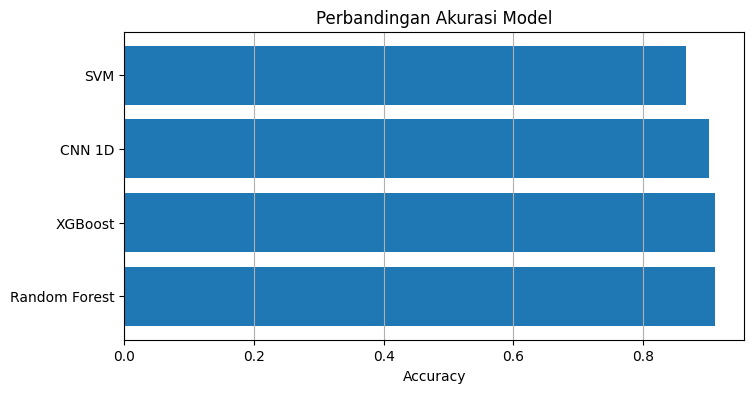

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.barh(accuracy_df.index, accuracy_df["Accuracy"])
plt.xlabel("Accuracy")
plt.title("Perbandingan Akurasi Model")
plt.grid(axis="x")
plt.show()


In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(4, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["No Device", "Electric Device"],
        yticklabels=["No Device", "Electric Device"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()


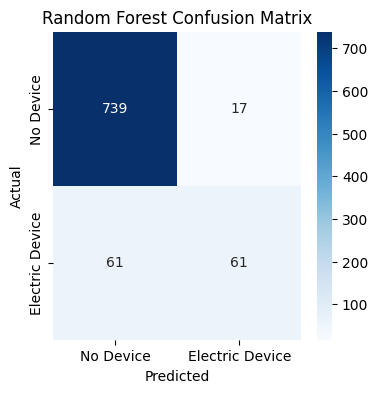

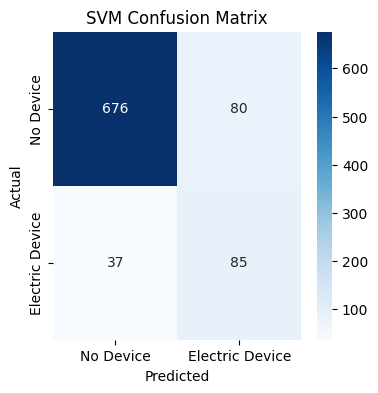

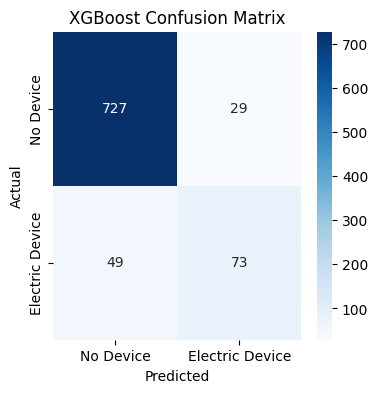

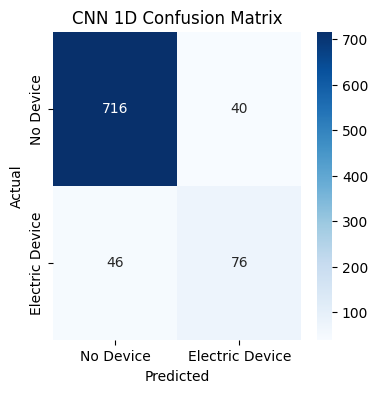

In [32]:
plot_confusion_matrix(y_test, rf_pred, "Random Forest Confusion Matrix")
plot_confusion_matrix(y_test, svm_pred, "SVM Confusion Matrix")
plot_confusion_matrix(y_test, xgb_pred, "XGBoost Confusion Matrix")
plot_confusion_matrix(y_test, cnn_pred, "CNN 1D Confusion Matrix")


In [33]:
from sklearn.metrics import classification_report

def get_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision (Device)": report["1"]["precision"],
        "Recall (Device)": report["1"]["recall"],
        "F1-Score (Device)": report["1"]["f1-score"]
    }

metrics = {
    "Random Forest": get_metrics(y_test, rf_pred),
    "SVM": get_metrics(y_test, svm_pred),
    "XGBoost": get_metrics(y_test, xgb_pred),
    "CNN 1D": get_metrics(y_test, cnn_pred)
}

metrics_df = pd.DataFrame(metrics).T.sort_values(
    by="F1-Score (Device)", ascending=False
)

metrics_df


,Accuracy,Precision (Device),Recall (Device),F1-Score (Device)
XGBoost,0.911162,0.715686,0.598361,0.651786
CNN 1D,0.902050,0.655172,0.622951,0.638655
Random Forest,0.911162,0.782051,0.500000,0.610000
SVM,0.866743,0.515152,0.696721,0.592334


In [34]:
best_model = metrics_df.index[0]
best_metrics = metrics_df.iloc[0]

print("🔎 MODEL TERBAIK BERDASARKAN F1-SCORE KELAS DEVICE")
print("Model :", best_model)
print(best_metrics)


🔎 MODEL TERBAIK BERDASARKAN F1-SCORE KELAS DEVICE
Model : XGBoost
Accuracy              0.911162
Precision (Device)    0.715686
Recall (Device)       0.598361
F1-Score (Device)     0.651786
Name: XGBoost, dtype: float64


Berdasarkan evaluasi:

- XGBoost dan Random Forest memiliki akurasi tertinggi (~91%)
- XGBoost unggul dalam:
  - F1-score kelas device
  - Precision–Recall tradeoff
  - Stabilitas prediksi

Sehingga XGBoost dipilih sebagai model utama untuk deployment.

## Insight Evaluasi

- Model cenderung lebih akurat mengenali non-device
- Tantangan utama adalah false negative (device tidak terdeteksi)
- Threshold probabilitas diperlukan untuk kontrol risiko

## Menyimpan model

In [35]:
import joblib

# Simpan scaler dan PCA
joblib.dump(scaler, "scaler.pkl")
joblib.dump(pca, "pca.pkl")

print("Scaler & PCA berhasil disimpan")


Scaler & PCA berhasil disimpan


In [36]:
joblib.dump(rf, "random_forest_model.pkl")
print("Random Forest berhasil disimpan")


Random Forest berhasil disimpan


In [37]:
joblib.dump(svm, "svm_model.pkl")
print("SVM berhasil disimpan")


SVM berhasil disimpan


In [38]:
joblib.dump(xgb, "xgboost_model.pkl")
print("XGBoost berhasil disimpan")


XGBoost berhasil disimpan


In [39]:
model.save("cnn_1d_model.keras")
print("CNN 1D berhasil disimpan (.keras)")


CNN 1D berhasil disimpan (.keras)


## Menyimpan data untuk test setelah deployment

In [40]:
import numpy as np
import pandas as pd

# Simpan 10 contoh deployment CSV
deploy_samples = X_deploy.iloc[:10]

for i, row in deploy_samples.iterrows():
    np.savetxt(f"deploy_input_{i}.csv", row.values, delimiter=",")


In [41]:
deploy_labels = y_deploy.iloc[:10]
deploy_labels.to_csv("deploy_labels_groundtruth.csv", index=False)


# Deployment
## Implementasi Aplikasi

Model XGBoost dideploy menggunakan Streamlit dengan fitur:

- Input:
  - CSV histogram
  - Gambar X-ray
  - Input manual histogram

- Pipeline otomatis:
Input → Histogram → Scaling → PCA → XGBoost → Probabilitas

- Confidence threshold

- Alert level (LOW / MEDIUM / HIGH)


### app.py

In [ ]:
import streamlit as st
import numpy as np
import joblib
import cv2
from PIL import Image
import shap
import matplotlib.pyplot as plt

# =========================================================
# CONFIG
# =========================================================
st.set_page_config(
    page_title="Electric Device Detection (X-ray)",
    page_icon="⚡",
    layout="centered"
)

# =========================================================
# LOAD MODEL & PREPROCESSING
# =========================================================
@st.cache_resource(show_spinner=False)
def load_models():
    xgb = joblib.load("xgboost_model.pkl")
    scaler = joblib.load("scaler.pkl")
    pca = joblib.load("pca.pkl")
    return xgb, scaler, pca

xgb, scaler, pca = load_models()

# =========================================================
# LOAD SHAP EXPLAINER
# =========================================================
explainer = shap.TreeExplainer(xgb)

# =========================================================
# UTILITY FUNCTIONS
# =========================================================
def is_likely_xray(image):
    img = np.array(image)

    if len(img.shape) == 3:
        std_r = np.std(img[:, :, 0])
        std_g = np.std(img[:, :, 1])
        std_b = np.std(img[:, :, 2])

        if abs(std_r - std_g) > 15 or abs(std_r - std_b) > 15:
            return False

        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    return np.std(img) <= 80


def image_to_histogram(image):
    img = np.array(image)

    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    img = cv2.resize(img, (256, 256))

    hist = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()

    return hist / hist.sum() if hist.sum() > 0 else hist


def preprocess_histogram(hist):
    hist = hist.reshape(1, -1)
    hist_scaled = scaler.transform(hist)
    hist_pca = pca.transform(hist_scaled)
    return hist_pca


def predict_histogram(hist):
    hist_pca = preprocess_histogram(hist)
    pred = xgb.predict(hist_pca)[0]
    prob = xgb.predict_proba(hist_pca)[0][1]
    return pred, prob, hist_pca


def get_alert_level(prob, threshold):
    if prob < threshold:
        return "LOW", "🟢", "Risiko rendah"
    elif prob < 0.85:
        return "MEDIUM", "🟡", "Perlu pemeriksaan tambahan"
    else:
        return "HIGH", "🔴", "PERINGATAN: Risiko tinggi"


# =========================================================
# UI
# =========================================================
st.title("⚡ Electric Device Detection System")

st.write(
    """
    Sistem ini mendeteksi **perangkat listrik** dari:
    - 📄 **CSV histogram**
    - 🩻 **Gambar X-ray**
    - ⌨️ **Input manual histogram**

    Pipeline:
    **Histogram → StandardScaler → PCA → XGBoost**
    """
)

st.markdown("---")

# =========================================================
# CONFIDENCE THRESHOLD
# =========================================================
st.subheader("⚙️ Confidence Threshold")

threshold = st.slider(
    "Threshold probabilitas deteksi",
    min_value=0.50,
    max_value=0.90,
    value=0.70,
    step=0.05
)

st.markdown("---")

# =========================================================
# INPUT METHOD
# =========================================================
input_method = st.radio(
    "Pilih metode input:",
    [
        "📄 Upload CSV Histogram",
        "🩻 Upload Gambar X-ray",
        "⌨️ Input Manual Histogram"
    ]
)

histogram = None

# =========================================================
# CSV INPUT
# =========================================================
if input_method == "📄 Upload CSV Histogram":
    uploaded_csv = st.file_uploader("Upload CSV (256 nilai)", type=["csv"])

    if uploaded_csv is not None:
        data = np.loadtxt(uploaded_csv, delimiter=",")
        if data.shape[0] != 256:
            st.error("CSV harus berisi 256 nilai")
            st.stop()

        histogram = data / data.sum()
        st.success("Histogram CSV valid")

# =========================================================
# IMAGE INPUT
# =========================================================
elif input_method == "🩻 Upload Gambar X-ray":
    uploaded_image = st.file_uploader("Upload gambar X-ray", type=["png", "jpg", "jpeg"])

    if uploaded_image is not None:
        image = Image.open(uploaded_image).resize((512, 512))
        st.image(image, caption="X-ray Input", use_column_width=True)

        if not is_likely_xray(image):
            st.warning("⚠️ Gambar kemungkinan bukan X-ray")

        histogram = image_to_histogram(image)

# =========================================================
# MANUAL INPUT
# =========================================================
elif input_method == "⌨️ Input Manual Histogram":
    manual_text = st.text_area(
        "Masukkan 256 nilai histogram (dipisahkan koma / spasi)",
        height=200
    )

    if manual_text.strip():
        try:
            values = np.array([float(v) for v in manual_text.replace(",", " ").split()])
            if values.shape[0] != 256:
                st.error("Jumlah nilai harus 256")
                st.stop()

            histogram = values / values.sum()
            st.success("Histogram manual valid")

        except ValueError:
            st.error("Input harus berupa angka")

# =========================================================
# PREDICTION + SHAP
# =========================================================
if histogram is not None:
    if st.button("🔍 Jalankan Prediksi"):
        with st.spinner("Memproses prediksi..."):
            pred, prob, hist_pca = predict_histogram(histogram)
            alert, icon, desc = get_alert_level(prob, threshold)

        st.markdown("---")
        st.subheader("📊 Hasil Prediksi")

        if pred == 1 and prob >= threshold:
            st.error(f"{icon} PERANGKAT LISTRIK TERDETEKSI")
        else:
            st.success("✅ TIDAK TERDETEKSI PERANGKAT LISTRIK")

        st.metric("Probabilitas Electric Device", f"{prob*100:.2f}%")
        st.metric("Alert Level", f"{icon} {alert}")
        st.caption(desc)

        st.subheader("📈 Histogram (Normalized)")
        st.line_chart(histogram)

        # =================================================
        # SHAP EXPLANATION
        # =================================================
        st.markdown("---")
        st.subheader("🧠 Penjelasan Model (SHAP)")

        with st.expander("Lihat penjelasan keputusan model"):
            shap_values = explainer.shap_values(hist_pca)

            fig, ax = plt.subplots(figsize=(8, 4))
            shap.plots.bar(
                shap.Explanation(
                    values=shap_values[0],
                    base_values=explainer.expected_value,
                    data=hist_pca[0],
                    feature_names=[f"PC{i+1}" for i in range(hist_pca.shape[1])]
                ),
                max_display=10,
                show=False
            )
            st.pyplot(fig)

# =========================================================
# FOOTER
# =========================================================
st.markdown("---")
st.caption("Model: XGBoost | Explainable AI (SHAP) | End-to-End System")
st.caption("Developed by NRSF")


### requirements.txt

In [ ]:
streamlit
numpy
scikit-learn
joblib
opencv-python-headless
Pillow
xgboost
shap
matplotlib


## Explainability (SHAP)

- Untuk meningkatkan kepercayaan pengguna:
- Digunakan SHAP TreeExplainer
- Menampilkan fitur PCA yang paling berpengaruh
- Mendukung interpretasi keputusan model

# Conclusion & Future Work

## Kesimpulan
- Sistem berhasil mendeteksi perangkat listrik dari citra X-ray
- Pendekatan histogram + ML terbukti efektif
- XGBoost memberikan performa terbaik secara keseluruhan



## Pengembangan Lanjutan
- Integrasi CNN 3D langsung dari voxel
- Penambahan ensemble model
- Kalibrasi threshold berbasis risiko bandara
- Dataset real-world tambahan